In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pickle


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/cvpr_dataset/CVPR FACE'
output_path = '/content/drive/My Drive/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:


IMG_SIZE = 128
haarcascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'

# Load Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(haarcascade_path)

# Prepare dataset
categories = os.listdir(dataset_path)
print("Categories:", categories)

data = []
labels = []

# Process each category folder
for category in categories:
    folder_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(folder_path):
        try:
            img_path = os.path.join(folder_path, img_name)
            img_array = cv2.imread(img_path)
            if img_array is None:
                print(f"Failed to load {img_path}")
                continue

            # Convert to grayscale for face detection
            gray_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            # Crop the first detected face (if any)
            if len(faces) > 0:
                x, y, w, h = faces[0]
                face = img_array[y:y + h, x:x + w]
                face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
                data.append(face)
                labels.append(category)
            else:
                print(f"No face detected in {img_path}")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Convert to numpy arrays
data = np.array(data, dtype=np.float32) / 255.0  # Normalize pixel values
labels = np.array(labels)

le = LabelEncoder()
labels = le.fit_transform(labels)






Categories: ['AVISHEK', 'LAMYEA', 'SAGOR']
No face detected in /content/drive/MyDrive/cvpr_dataset/CVPR FACE/AVISHEK/IMG_20241207_121015.jpg
No face detected in /content/drive/MyDrive/cvpr_dataset/CVPR FACE/LAMYEA/WhatsApp Image 2024-12-06 at 1.14.24 PM (5).jpeg
No face detected in /content/drive/MyDrive/cvpr_dataset/CVPR FACE/LAMYEA/WhatsApp Image 2024-12-06 at 1.14.24 PM (3).jpeg
No face detected in /content/drive/MyDrive/cvpr_dataset/CVPR FACE/LAMYEA/WhatsApp Image 2024-12-06 at 1.14.24 PM (4).jpeg
No face detected in /content/drive/MyDrive/cvpr_dataset/CVPR FACE/LAMYEA/WhatsApp Image 2024-12-06 at 1.14.35 PM.jpeg
No face detected in /content/drive/MyDrive/cvpr_dataset/CVPR FACE/LAMYEA/WhatsApp Image 2024-12-06 at 1.14.32 PM.jpeg
No face detected in /content/drive/MyDrive/cvpr_dataset/CVPR FACE/LAMYEA/WhatsApp Image 2024-12-06 at 1.14.24 PM.jpeg
No face detected in /content/drive/MyDrive/cvpr_dataset/CVPR FACE/LAMYEA/WhatsApp Image 2024-12-06 at 1.14.35 PM (1).jpeg
No face detected 

In [5]:
# Save category mapping for later use
category_names = {i: c for i, c in enumerate(le.classes_)}
with open("/content/drive/MyDrive/FACE RECOGNIZATION SYSTEM/categories.pkl", "wb") as file:
    pickle.dump(category_names, file)
print("Category mapping saved:", category_names)

Category mapping saved: {0: np.str_('AVISHEK'), 1: np.str_('LAMYEA'), 2: np.str_('SAGOR')}


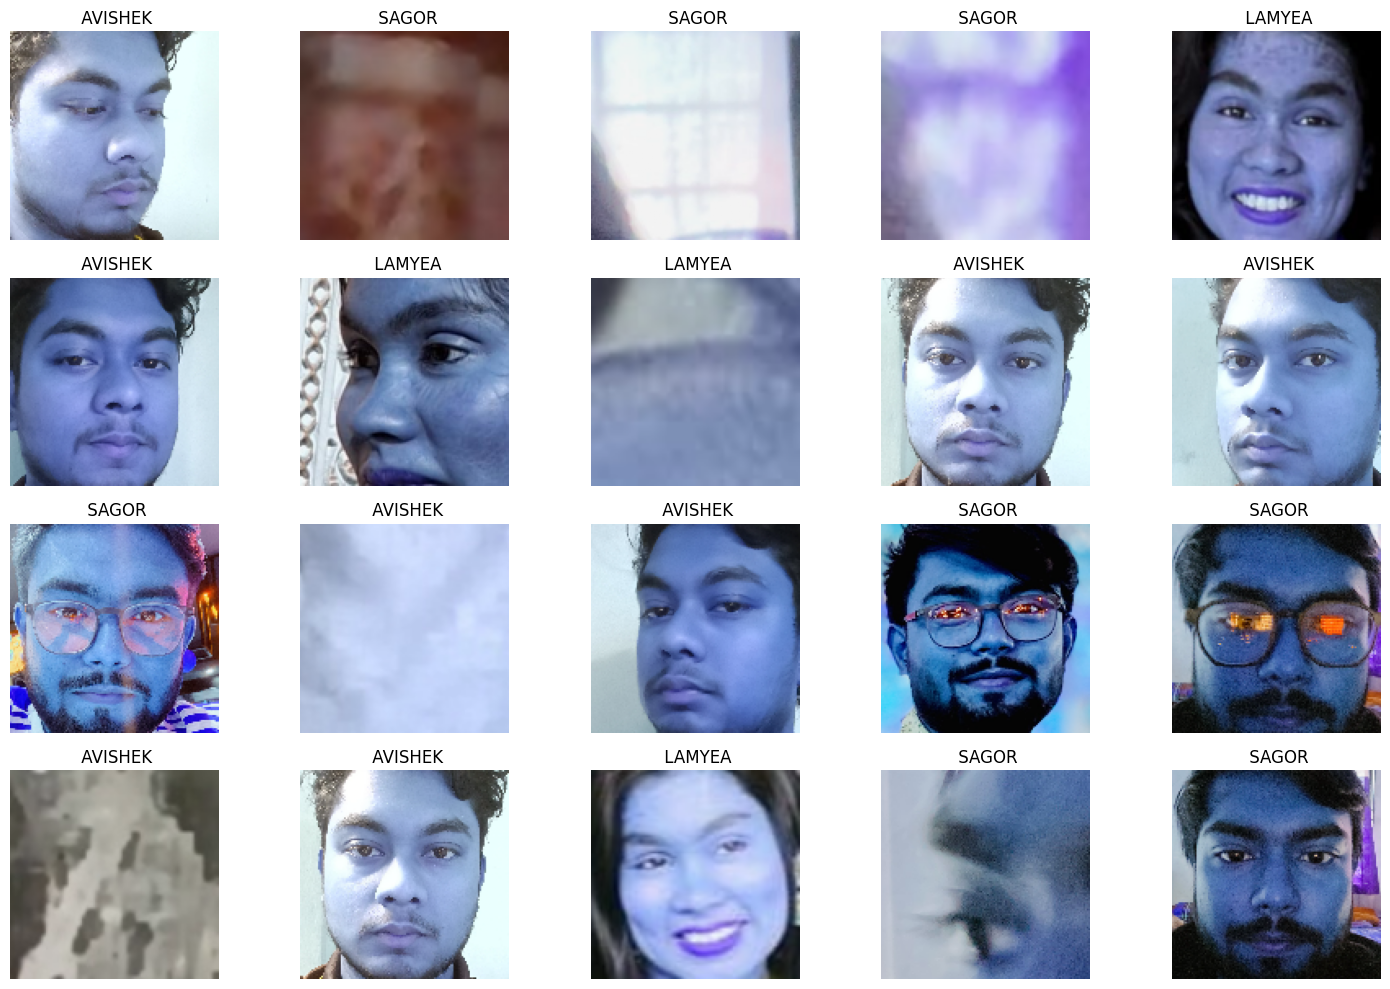

In [6]:
import random
import matplotlib.pyplot as plt


random_indices = random.sample(range(len(data)), 20)


plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(data[idx])
    plt.title(f" {category_names[labels[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42
)

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=len(categories))
y_val = to_categorical(y_val, num_classes=len(categories))


print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

Training data shape: (235, 128, 128, 3)
Validation data shape: (59, 128, 128, 3)
Training labels shape: (235, 3)
Validation labels shape: (59, 3)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(categories), activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


best_model_path = "/content/drive/MyDrive/FACE RECOGNIZATION SYSTEM_model.keras"

# Create callbacks
checkpoint = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_loss',
    save_best_only=True,
    # Save the entire model (not just weights)
    save_weights_only=False,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16,
    callbacks=[checkpoint, early_stopping]
)







Epoch 1/10
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6935 - loss: 0.8243
Epoch 1: val_loss improved from inf to 0.70003, saving model to /content/drive/MyDrive/FACE RECOGNIZATION SYSTEM_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6958 - loss: 0.8193 - val_accuracy: 0.6949 - val_loss: 0.7000
Epoch 2/10
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7519 - loss: 0.6058
Epoch 2: val_loss improved from 0.70003 to 0.59009, saving model to /content/drive/MyDrive/FACE RECOGNIZATION SYSTEM_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7479 - loss: 0.6119 - val_accuracy: 0.7458 - val_loss: 0.5901
Epoch 3/10
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7831 - loss: 0.5062
Epoch 3: val_loss improved from 0.59009 to 0.56246, saving model to /content/drive/MyDrive/FACE RECOGNIZATION SYSTEM_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7876 - loss: 0.4981 - val_accuracy: 0.7119 - val_loss: 0.5625
Epoch 4/10
13/

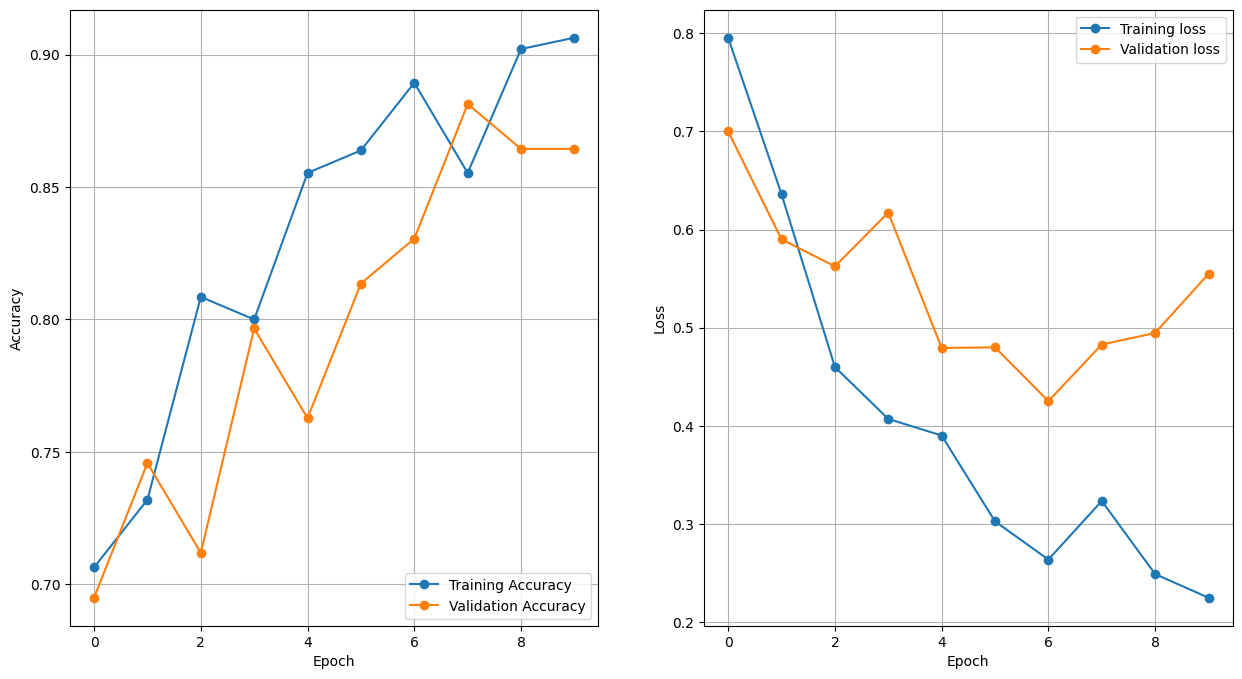

In [12]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'o-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='Training loss')
plt.plot(history.history['val_loss'], 'o-', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()


In [13]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     7,372,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,232,843 (84.81 MB)

 Trainable params: 7,410,947 (28.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,821,896 (56.54 MB)

In [14]:
# Save label encoder, images, and category names
with open(os.path.join(output_path, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(le, f)


with open(os.path.join(output_path, 'data.pkl'), 'wb') as f:
    pickle.dump({'X_train': X_train, 'X_val': X_val, 'y_train': y_train, 'y_val': y_val}, f)


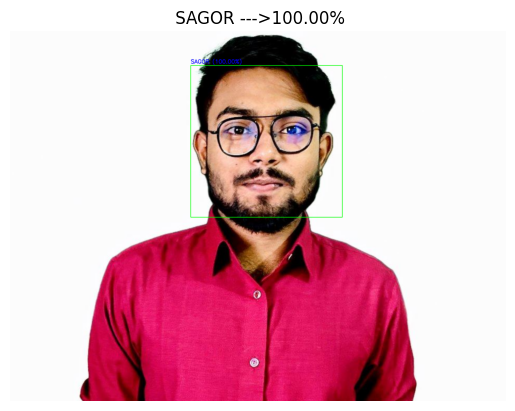

In [16]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pickle

# Load the saved model
model = load_model('/content/drive/MyDrive/FACE RECOGNIZATION SYSTEM_model.keras')

# Load the label encoder or class labels
with open('/content/drive/MyDrive/categories.pkl', 'rb') as f:
    class_labels = pickle.load(f)

# Haar cascade path for face detection
haarcascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(haarcascade_path)

# Function to preprocess the face
def preprocess_face(face, target_shape):
    normalized_face = cv2.resize(face, (target_shape[1], target_shape[2])) / 255.0
    face_array = np.expand_dims(normalized_face, axis=0)
    return face_array

# Function to recognize and display the result
def recognize_image_with_haarcascade(image_path, confidence_threshold=0.7):
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image from {image_path}")
        return

    # Convert the image to grayscale for Haar cascade
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No face detected.")
        return

    # Process the first detected face
    x, y, w, h = faces[0]
    face = img[y:y+h, x:x+w]  # Crop the detected face

    # Preprocess the face
    face_array = preprocess_face(face, model.input_shape)

    # Predict the label
    predictions = model.predict(face_array, verbose=0)
    confidence = np.max(predictions)
    label_index = np.argmax(predictions)
    label = class_labels[label_index] if confidence >= confidence_threshold else "Unknown"

    # Display the result
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(
        img,
        f"{label} ({confidence*100:.2f}%)",
        (x, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (255, 0, 0),
        2,
    )

    # Display the image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f" {label} --->{confidence*100:.2f}%")
    plt.show()

# Path to the image you want to recognize
image_path = '/content/drive/MyDrive/cvpr_dataset/CVPR FACE/SAGOR/Firefly 202411012342215044.png'  # Update this to your image path

# Recognize the image using Haar cascade
recognize_image_with_haarcascade(image_path, confidence_threshold=0.85)
